# <center>Índice Climático referente a Arboviroses relacionadas ao mosquito Aedes Aegypti</center>
---
## <center>Construção do índice climático integrado<center>

Desenvolvido por:
* <b>George Ulguim Pedra</b> - gupbadabum@gmail.com

Criado:     23-08-2024

Atualizado: 23-09-2024

In [1]:
# Limpando a memoria
rm(list=ls())

#### Bibliotecas ####

In [2]:
library('openxlsx')
library('ResourceSelection')
library('ggplot2')
library('rgdal')

ResourceSelection 0.3-6 	 2023-06-27

Loading required package: sp

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.3.3, released 2021/10/25
Path to GDAL shared files: /home/hellgate/anaconda3/envs/r-env/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.1.1, September 1st, 2021, [PJ_VERSION: 811]
Path to PROJ shared files: /home/hellgate/anaconda3/envs/r-env/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.



#### Funções Primárias ####

As funções aqui utilizadas são derivadas do repositório <b>InformationValue</b>. No link abaixo é possível verificar a descrição e explicações mais detalhadas, seja sobre o pacote ou as funções nele disponibilizadas.

https://www.rdocumentation.org/packages/InformationValue/versions/1.2.3

In [3]:
Concordance <- function (actuals, predictedScores){
  fitted <- data.frame (Actuals=actuals, PredictedScores=predictedScores) # actuals and fitted
  colnames(fitted) <- c('Actuals','PredictedScores') # rename columns
  ones <- na.omit(fitted[fitted$Actuals==1, ]) # Subset ones
  zeros <- na.omit(fitted[fitted$Actuals==0, ]) # Subsetzeros
  totalPairs <- nrow (ones) * nrow (zeros) # calculate total number of pairs to check
  conc <- sum (c (vapply (ones$PredictedScores, function(x) {((x > zeros$PredictedScores))}, FUN.VALUE=logical(nrow(zeros)))), na.rm=T)
  disc <- sum(c(vapply(ones$PredictedScores, function(x) {((x < zeros$PredictedScores))}, FUN.VALUE = logical(nrow(zeros)))), na.rm = T)
  disc <- totalPairs - conc

  # Calcula a concordância, discordância e os empates
  concordance <- conc/totalPairs
  discordance <- disc/totalPairs
  tiesPercent <- (1-concordance-discordance)
  return(list("Concordance"=concordance, "Discordance"=discordance,
              "Tied"=tiesPercent, "Pairs"=totalPairs))
}


misClassError <- function(actuals, predictedScores, threshold=0.5){
  predicted_dir <- ifelse(predictedScores < threshold, 0, 1)
  actual_dir <- actuals
  return(round(sum(predicted_dir != actual_dir, na.rm=T)/length(actual_dir), 4))
}

sensitivity <- function(actuals, predictedScores, threshold=0.5){
  predicted_dir <- ifelse(predictedScores < threshold, 0, 1)
  actual_dir <- actuals
  no_with_and_predicted_to_have_event <- sum(actual_dir == 1 & predicted_dir == 1, na.rm=T)
  no_with_event <- sum(actual_dir == 1, na.rm=T)
  return(no_with_and_predicted_to_have_event/no_with_event)
}

specificity <- function(actuals, predictedScores, threshold=0.5){
  predicted_dir <- ifelse(predictedScores < threshold, 0, 1)
  actual_dir <- actuals
  no_without_and_predicted_to_not_have_event <- sum(actual_dir != 1 & predicted_dir != 1, na.rm=T)
  no_without_event <- sum(actual_dir != 1, na.rm=T)
  return(no_without_and_predicted_to_not_have_event/no_without_event)
}

precision <- function(actuals, predictedScores, threshold=0.5){
  predicted_dir <- ifelse(predictedScores < threshold, 0, 1)
  actual_dir <- actuals
  no_with_and_predicted_to_have_event <- sum(actual_dir == 1 & predicted_dir == 1, na.rm=T)
  no_predicted_event <- sum(predicted_dir == 1, na.rm=T)
  return(no_with_and_predicted_to_have_event/no_predicted_event)
}

npv <- function(actuals, predictedScores, threshold=0.5){
  predicted_dir <- ifelse(predictedScores < threshold, 0, 1)
  actual_dir <- actuals
  no_without_and_predicted_to_not_have_event <- sum(actual_dir != 1 & predicted_dir != 1, na.rm=T)
  no_predicted_to_not_have_event <- sum(predicted_dir != 1, na.rm=T)
  return(no_without_and_predicted_to_not_have_event/no_predicted_to_not_have_event)
}

confusionMatrix <- function(actuals, predictedScores, threshold=0.5){
  predicted_dir <- ifelse(predictedScores < threshold, 0, 1)
  actual_dir <- actuals
  return (as.data.frame.matrix(table(predicted_dir, actual_dir)))
}


WOETable <- function(X, Y, valueOfGood=1){
  yClasses <- unique(Y)
  if(length(yClasses) == 2) {  # ensure it is binary
    # covert good's to 1 and bad's to 0.
    Y[which(Y==valueOfGood)] <- 1
    Y[which(!(Y=="1"))] <- 0
    Y <- as.numeric(Y)
    df <- data.frame(X, Y)

    # Create WOE table
    woeTable <- as.data.frame(matrix(numeric(nlevels(X) * 8), nrow=nlevels(X), ncol=8))
    names(woeTable) <- c("CAT", "GOODS", "BADS", "TOTAL", "PCT_G", "PCT_B", "WOE", "IV")
    woeTable$CAT <- levels(X)  # load categories to table.

    # Load the number of goods and bads within each category.
    for(catg in levels(X)){  # catg => current category
      try(woeTable[woeTable$CAT == catg, c(3, 2)] <- table(Y[X==catg]), silent=T)  # assign the good and bad count for current category.
      woeTable[woeTable$CAT == catg, "TOTAL"] <- sum(X==catg , na.rm=T)
    }

    woeTable$PCT_G <- woeTable$GOODS/sum(woeTable$GOODS, na.rm=T)  # compute % good
    woeTable$PCT_B <- woeTable$BADS /sum(woeTable$BADS, na.rm=T)  # compute % bad
    woeTable$WOE <- log(woeTable$PCT_G / woeTable$PCT_B)  # compute WOE
    woeTable$IV <- (woeTable$PCT_G - woeTable$PCT_B) * woeTable$WOE  # compute IV
    attr(woeTable, "iValue") <- sum(woeTable$IV, na.rm=T)  # assign iv as attribute..
    return(woeTable)
  } else {
    stop("WOE can't be computed because the Y is not binary.")
  }
}

Index.map<-function(X2,INPUT,COLNUM){
    col.map<-ncol(X2@data) ; 
    {if(COLNUM==1)
        {col.input<-1}
    else    
        {col.input<-NCOL(INPUT[,-c(1:COLNUM)])}
    }

    NAMES<-colnames(INPUT)

    MAPA1<-X2
    
    {if(col.input==1)
        {MAPA1@data[,col.map+1]<-NA}
    else    
        {MAPA1@data[,c((col.map+1):(col.map+col.input))]<-NA}
    }

        for(i in 1:nrow(INPUT)){
            pos<-which(X2@data[,1]==INPUT[i,1])
            MAPA1@data[pos,-c(1:col.map)]<-INPUT[i,-c(1:COLNUM)]
        }
    colnames(MAPA1@data)<-c(colnames(X2@data),NAMES[-c(1:COLNUM)])
        
    return(MAPA1)
}


# Criação da Figura
Make.map<-function(X1,X2,INFO,WIDTH,HEIGHT,RES,TITLE,PRINT=0,MAP=0,COLSTART){
    # X1:       Objeto shapefile com informacoes
    # X2:       Objeto shapefile vazio
    # INFO:     Data Frame contendo duas colunas.
    # WIDTH:    Multiplicador do comprimento/largura
    # HEIGHT:   Multiplicador da altura
    # RES:      numero de DPI

    output<-getwd()

    subDir1<-paste0('../4-Output/Resultado/',TITLE,'/tmp/')
        
    ifelse(!dir.exists(file.path(output,subDir1)),dir.create(file.path(subDir1),showWarnings=FALSE,recursive=TRUE), FALSE)

    col.empty<-COLSTART ; col.val<-ncol(X1@data)
    
    brks1<-c(0,.2,.4,.6,.8,1)
    
    COD<-colnames(X1@data)

    Comp.ind<-unique(nchar(INFO[,1]))

    TOPX<-(-ceiling(max(X2@bbox[1,])-min(X2@bbox[1,]))) + 4
    TOPY<-as.integer(max(X2@bbox[2,]))
    
    for(i in c((col.empty):(col.val))){

        File<-paste0(subDir1,COD[i],'.png')

        IND<-COD[i]

        L<-INFO[IND==INFO[,1],3]
        TITULO<-INFO[IND==INFO[,1],2]
        
        {if(L==1)
            {cols<-c('darkgreen','green2','khaki1','darkorange','red')}
        }

        {if(L==0)
            {cols<-rev(c('darkgreen','green2','khaki1','darkorange','red'))}
        }
        
        classes<-c('NO DATA','Muito Baixo','Baixo','Moderado','Alto','Muito Alto')
        png(File,width=(WIDTH*480),height=(HEIGHT*480),type='cairo',res=RES)
        #par(mar=c(1,1,1,1),mai=c(.01,0.01,0.01,0.01),oma=c(.1,.1,.1,.1))
        par(mar=c(1,1,1,1),mai=c(.01,0.01,0.5,0.01),oma=c(.1,.1,.1,.1))
        plot(X2, col='gray',border=NA,main=TITULO,cex=.25)
        plot(X1, col=cols[findInterval(X1@data[,i],brks1,all.inside=TRUE)],border=NA,add=T)
        legend('bottomleft',title='Classes',legend=classes,border=c('gray',cols),fill=c('gray',cols),bty="n",cex=0.75)
        if(PRINT==1) {text(TOPX,TOPY,COD[i],cex=0.5)}
        if(MAP==1) {plot(X2,add=T,lwd=0.25)}
        dev.off()
    }
}


##### Funções Secundárias #####

In [4]:
#
somersD <- function(actuals, predictedScores){
  conc_disc <- Concordance(actuals, predictedScores)
  return (conc_disc$Concordance - conc_disc$Discordance)
}

#
youdensIndex <- function(actuals, predictedScores, threshold=0.5){
  Sensitivity <- sensitivity(actuals, predictedScores, threshold = threshold)
  Specificity <- specificity(actuals, predictedScores, threshold = threshold)
  return(Sensitivity + Specificity - 1)
}

#
kappaCohen <- function(actuals, predictedScores, threshold=0.5){
  conf <- confusionMatrix(actuals=actuals, predictedScores=predictedScores, threshold=threshold)
  prob_agreement <- conf[1, 1] + conf[2, 2]
  prob_expected <- sum(conf[2, ])/sum(conf) * sum(conf[, 2])/sum(conf)   # probability of actual 'yes' * probability of predicting 'yes'.
  return((prob_agreement - prob_expected)/(1-(prob_expected)))
}

#
# Compute specificity and sensitivity
getFprTpr<- function(actuals, predictedScores, threshold=0.5){
  return(list(1-specificity(actuals=actuals, predictedScores=predictedScores, threshold=threshold),
              sensitivity(actuals=actuals, predictedScores=predictedScores, threshold=threshold)))
}

#
WOE <- function(X, Y, valueOfGood=1){
  woeTable <- WOETable(X=X, Y=Y, valueOfGood = valueOfGood)
  return(woeTable[match(X, woeTable[, 1]), "WOE"])  # lookup corresponding value of WOE for each X in woeTable
}

#
IV <- function(X, Y, valueOfGood=1){
  woeTable <- WOETable(X=X, Y=Y, valueOfGood=valueOfGood)
  iv <- sum(woeTable[, "IV"], na.rm=T)

  # Descreve a habilidade preditiva
  if(iv < 0.03) {
    attr(iv, "howgood") <- "Not Predictive"
  } else if(iv < 0.1) {
    attr(iv, "howgood") <- "Somewhat Predictive"
  } else {
    attr(iv, "howgood") <- "Highly Predictive"
  }
  return(iv)  # Procura o valor correspondente de WOE para cada X (elemento) em woeTable
}

#
optimalCutoff <- function(actuals, predictedScores, optimiseFor="misclasserror", returnDiagnostics=FALSE){
  # inicializa o dataframe de diagnóstico para estudar o efeito de vários valores de corte.
  sequence <- seq(max(predictedScores), min(predictedScores), -0.01)
  sensMat <- data.frame(CUTOFF=sequence, FPR= numeric(length(sequence)),TPR= numeric(length(sequence)), YOUDENSINDEX=numeric(length(sequence)))
  sensMat[, c(2:3)] <- as.data.frame(t(mapply(getFprTpr, threshold=sequence, MoreArgs=list(actuals=actuals, predictedScores=predictedScores))))
  sensMat$YOUDENSINDEX <- mapply(youdensIndex, threshold=sequence, MoreArgs=list(actuals=actuals, predictedScores=predictedScores))
  sensMat$SPECIFICITY <- (1 - as.numeric(sensMat$FPR))
  sensMat$MISCLASSERROR <- mapply(misClassError, threshold=sequence, MoreArgs=list(actuals=actuals, predictedScores=predictedScores))

  # Seleciona o corte
  if(optimiseFor=="Both"){
    rowIndex <- which(sensMat$YOUDENSINDEX == max(as.numeric(sensMat$YOUDENSINDEX)))[1]  # escolha o corte máximo
  }else if(optimiseFor=="Ones"){
    rowIndex <- which(sensMat$TPR == max(as.numeric(sensMat$TPR)))[1]  # escolha o corte máximo
  }else if(optimiseFor=="Zeros"){
    rowIndex <- tail(which(sensMat$SPECIFICITY == max(as.numeric(sensMat$SPECIFICITY))), 1)  # escolha o corte mínimo
  }else if(optimiseFor=="misclasserror"){
    rowIndex <- tail(which(sensMat$MISCLASSERROR == min(as.numeric(sensMat$MISCLASSERROR))), 1)  #  escolha o corte mínimo
  }

  # O que a função deve retornar
  if(!returnDiagnostics){
    return(sensMat$CUTOFF[rowIndex])
  } else {
    output <- vector(length=6, mode="list")  # Inicialize a saída de diagnóstico
    names(output) <- c("optimalCutoff", "sensitivityTable", "misclassificationError", "TPR", "FPR", "Specificity")  # Nomeando os elementos
    output$optimalCutoff <- sensMat$CUTOFF[rowIndex]
    output$sensitivityTable <- sensMat
    output$misclassificationError <- misClassError(actuals, predictedScores, threshold=sensMat$CUTOFF[rowIndex])
    output$TPR <- getFprTpr(actuals, predictedScores, threshold=sensMat$CUTOFF[rowIndex])[[2]]
    output$FPR <- getFprTpr(actuals, predictedScores, threshold=sensMat$CUTOFF[rowIndex])[[1]]
    output$Specificity <- sensMat$SPECIFICITY[rowIndex]
    return(output)
  }
}

# 
AUROC <- function(actuals, predictedScores){
  # Identificando o número de linhas no objeto
  numrow = length(seq(max(predictedScores, 1, na.rm=T), (min(predictedScores, 0, na.rm=T)-0.02), by=-0.02))

  # Crie os valores dos eixos X e Y em um dataframe
  df <- as.data.frame(matrix(numeric(numrow*2), ncol=2))  # Inicializando
  names(df) <- c("One_minus_specificity", "sensitivity")  # Nomeando as colunas
  rowcount = 1

  for (threshold in seq(max(predictedScores, 1, na.rm=T), (min(predictedScores, 0, na.rm=T)-0.02), by=-0.02)){
    df[rowcount, ] <- getFprTpr(actuals=actuals, predictedScores=predictedScores, threshold=threshold)
    rowcount <- rowcount + 1
  }

  df <- data.frame(df, Threshold=seq(max(predictedScores, 1, na.rm=T), (min(predictedScores, 0, na.rm=T)-0.02), by=-0.02))  # Anexando Limite

  # Calculando a Área sob a Curva ROC.
  auROC <- 0  # Inicializando
  for(point in c(2:nrow(df))) {
    x1 <- df[point-1, 1]
    x2 <- df[point, 1]
    y1 <- df[point-1, 2]
    y2 <- df[point, 2]
    # cat("x1, x2, y1, y2:", x1, x2, y1, y2)

    # Computando a area da figura rect_area
    rect_x <- x2 - x1
    rect_y <- y1
    rect_area <- rect_x * rect_y
    # cat("rect_x, rect_y, rect_area:", rect_x, rect_y, rect_area)

    # Computando a area do triangulo
    triangle_area <- rect_x * (y2-y1) * 0.5
    currArea <- rect_area + triangle_area
    auROC <- auROC + currArea
  }
  totalArea <- (max(df[, 1]) * max(df[, 2]))
  return(auROC/totalArea)  # auROC/totalArea
}


#
plotROC <- function(actuals, predictedScores,TITLE,Show.labels=F, returnSensitivityMat=F){

  One_minus_specificity <- Threshold.show <- NULL  # setting to NULL to avoid NOTE while doing devtools::check

  # get the number of rows in df
  numrow = length(seq(max(predictedScores, 1, na.rm=T), (min(predictedScores, 0, na.rm=T)-0.02), by=-0.02))

  # create the x(True positive) and y(False positive) axis values in a df
  df <- as.data.frame(matrix(numeric(numrow*2), ncol=2))# initialise
  names(df) <- c("One_minus_specificity", "sensitivity")  # give col names.
  rowcount = 1

  for (threshold in seq(max(predictedScores, 1, na.rm=T), (min(predictedScores, 0, na.rm=T)-0.02), by=-0.02)){
    df[rowcount, ] <- getFprTpr(actuals=actuals, predictedScores=predictedScores, threshold=threshold)
    rowcount <- rowcount + 1
  }

  AREAROC <- AUROC(actuals=actuals, predictedScores=predictedScores)  # compute area under ROC

  df <- data.frame(df, Threshold=seq(max(predictedScores, 1, na.rm=T), (min(predictedScores, 0, na.rm=T)-0.02), by=-0.02))  # append threshold

  df$Threshold.show <- rep(NA, nrow(df))
  # Adding Thresholds to show.
  for (rownum in c(2:nrow(df))){
    if(df[rownum, 1] != df[rownum-1, 1]  |  df[rownum, 2] != df[rownum-1, 2]){
      df$Threshold.show[rownum] <-  df$Threshold[rownum]
    }
  }

  COLOR<-ifelse(AREAROC<0.1,'darkred',
          ifelse(AREAROC>=0.1 & AREAROC<0.2,'red',
          ifelse(AREAROC>=0.2 & AREAROC<0.3,'orange',
          ifelse(AREAROC>=0.3 & AREAROC<0.4,'yellow',
          ifelse(AREAROC>=0.4 & AREAROC<0.5,'khaki1',
          ifelse(AREAROC>=0.5 & AREAROC<0.6,'lightcyan',
          ifelse(AREAROC>=0.6 & AREAROC<0.7,'skyblue1',
          ifelse(AREAROC>=0.7 & AREAROC<0.8,'steelblue',
          ifelse(AREAROC>=0.8 & AREAROC<0.9,'blue','midnightblue')))))))))
  # Plot it
  bp <- ggplot(df, aes(One_minus_specificity, sensitivity, label=Threshold.show))


  # If Show.labels is TRUE, then display the labels.
  if(!Show.labels){
    print(bp + geom_ribbon(color=COLOR, fill=COLOR, aes(ymin=0, ymax=sensitivity)) +
      labs(title=TITLE,subtitle="ROC Curve", x="1-Specificity (FPR)", y="Sensitivity (TPR)") +
      annotate("text", label=paste("AUROC:", round(AREAROC, 4)), x=0.55, y=0.35, colour="white", size=8) +
      theme(legend.position="none",
            plot.title=element_text(size=20, colour = "black"),
            axis.title.x=element_text(size=15, colour = "black"),
            axis.title.y=element_text(size=15, colour = "black")) + coord_cartesian(xlim=c(0,1), ylim = c(0,1)))
  } else {
    print(bp + geom_ribbon(color=COLOR, fill=COLOR, aes(ymin=0, ymax=sensitivity)) +
      labs(title=TITLE,subtitle="ROC Curve", x="1-Specificity (FPR)", y="Sensitivity (TPR)") +
      annotate("text", label=paste("AUROC:", round(AREAROC, 4)), x=0.55, y=0.35, colour="white", size=8) +
      theme(legend.position="none",
            plot.title=element_text(size=20, colour = "black"),
            axis.title.x=element_text(size=15, colour = "black"),
            axis.title.y=element_text(size=15, colour = "black")) +  geom_text(aes(size=0.1)) + coord_cartesian(xlim=c(0,1), ylim = c(0,1)))
  }

  if(returnSensitivityMat){
    return(df[, c(1:3)])
  }

}


#### Leitura de Shapefile ####

In [5]:
map0 <- readOGR('/media/hellgate/16D7D0A761E2DB6A/MEGA/Shapefiles/Br_2019/br_municipios/BR_Municipios_2019.shp') # Shapefile referente aos municipios brasileiros

map_bac <- readOGR('/media/hellgate/16D7D0A761E2DB6A/MEGA/Shapefiles/Br_uf_5000/uf_5000.shp') # Shapefile referente as unidades federativas

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000 in Proj4 definition: +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs”


OGR data source with driver: ESRI Shapefile 
Source: "/media/hellgate/16D7D0A761E2DB6A/MEGA/Shapefiles/Br_2019/br_municipios/BR_Municipios_2019.shp", layer: "BR_Municipios_2019"
with 5572 features
It has 4 fields


Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000 in Proj4 definition: +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs”


OGR data source with driver: ESRI Shapefile 
Source: "/media/hellgate/16D7D0A761E2DB6A/MEGA/Shapefiles/Br_uf_5000/uf_5000.shp", layer: "uf_5000"
with 30 features
It has 7 fields


#### Leitura das informações referente ao desfecho e climáticas ####

In [6]:
Arbo<-read.xlsx('../2-Input/tx_incid_arbovirosesAa_2017a2022.xlsx') # Referente a Arboviroses

hurs<-read.csv(file='../2-Input/Indicador_Simples_HURS.csv',sep=';',dec=',',header=T) # Umidade Relativa
sdii<-read.csv(file='../2-Input/Indicador_Simples_SDII.csv',sep=';',dec=',',header=T)  # Indice Simples de precipitação 
dift<-read.csv(file='../2-Input/Indicador_Simples_DIFT.csv',sep=';',dec=',',header=T)  # Amplitude Térmica 
tasmax<-read.csv(file='../2-Input/Indicador_Simples_TASMAX.csv',sep=';',dec=',',header=T) # Temperatura Máxima
tasmin<-read.csv(file='../2-Input/Indicador_Simples_TASMIN.csv',sep=';',dec=',',header=T) # Temperatura Mínima 
oc_dur<-read.csv(file='../2-Input/Indicador_Simples_OC_duracao.csv',sep=';',dec=',',header=T) # Duração Máxima de Onda de Calor
oc_con<-read.csv(file='../2-Input/Indicador_Simples_OC_contagem.csv',sep=';',dec=',',header=T) # Número de Ocorrência de Ondas de Calor

In [7]:
head(Arbo)
colnames(Arbo)
dim(Arbo)

,geocode6,geocode7,Municipio,UF,BIOMA,d_2017,d_2018,d_2019,d_2020,d_2021,⋯,soma_not_2021,soma_not_2022,soma_not_tot,tx_inc_arbo2017,tx_inc_arbo2018,tx_inc_arbo2019,tx_inc_arbo2020,tx_inc_arbo2021,tx_inc_arbo2022,média_tx_period
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,110001,1100015,ALTA FLORESTA D'OESTE,RO,Amazônia,16,4,230,9,4,⋯,4,400,670,66.83178,17.26594,1028.54652,39.59873,17.76514,1860.8979,505.1510
2,110002,1100023,ARIQUEMES,RO,Amazônia,61,11,33,157,55,⋯,63,1115,1498,62.41558,15.07045,42.64669,174.39259,56.68118,1151.4670,250.4456
3,110003,1100031,CABIXI,RO,Amazônia,5,4,94,11,1,⋯,1,25,154,80.33419,73.55645,2033.13253,212.02776,19.73554,466.1570,480.8239
4,110004,1100049,CACOAL,RO,Amazônia,25,21,25,94,206,⋯,214,2085,2520,38.41504,44.80445,56.23309,117.58816,247.63933,2399.4476,484.0213
5,110005,1100056,CEREJEIRAS,RO,Amazônia,254,10,14,158,5,⋯,6,39,514,1511.09624,60.81245,128.65282,1030.60973,37.29488,245.4374,502.3173
6,110006,1100064,COLORADO DO OESTE,RO,Amazônia,15,17,11,70,8,⋯,23,11,148,81.22597,110.92623,69.26080,450.33453,151.18649,70.2292,155.5272


[1] "geocode6"        "geocode7"        "Municipio"       "UF"             
 [5] "BIOMA"           "d_2017"          "d_2018"          "d_2019"         
 [9] "d_2020"          "d_2021"          "d_2022"          "d_total_period" 
[13] "c_2017"          "c_2018"          "c_2019"          "c_2020"         
[17] "c_2021"          "c_2022"          "c_total_period"  "z_2017"         
[21] "z_2018"          "z_2019"          "z_2020"          "z_2021"         
[25] "z_2022"          "z_total_period"  "pop2017"         "pop2018"        
[29] "pop2019"         "pop2020"         "pop2021"         "pop2022"        
[33] "soma_not_2017"   "soma_not_2018"   "soma_not_2019"   "soma_not_2020"  
[37] "soma_not_2021"   "soma_not_2022"   "soma_not_tot"    "tx_inc_arbo2017"
[41] "tx_inc_arbo2018" "tx_inc_arbo2019" "tx_inc_arbo2020" "tx_inc_arbo2021"
[45] "tx_inc_arbo2022" "média_tx_period"

[1] 5570   46

In [8]:
head(hurs)

,CD_GEOCMU,NM_MUNICIP,Hist,RCP45.2030,RCP45.2050,RCP85.2030,RCP85.2050
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1100015,Alta Floresta D'Oeste,0.50,0.46,0.42,0.44,0.40
2,1100023,Ariquemes,0.50,0.45,0.41,0.43,0.39
3,1100049,Cacoal,0.41,0.38,0.33,0.35,0.31
4,1100056,Cerejeiras,0.44,0.41,0.37,0.38,0.35
5,1100064,Colorado do Oeste,0.46,0.42,0.38,0.39,0.36
6,1100080,Costa Marques,0.45,0.41,0.38,0.39,0.36


##### Criando dataframe a ser utilizado #####

In [9]:
datah<-data.frame(GEOCOD=hurs[,1],NM_MUN=hurs[,2],CAT=NA,PDMED=NA,PROB=NA,AMPT=NA,HURS=hurs[,3],RAIN=NA,TASMAX=NA,TASMIN=NA,WSDI_D=NA,WSDI_C=NA)

data2030O<-data.frame(GEOCOD=hurs[,1],NM_MUN=hurs[,2],AMPT=NA,HURS=hurs[,4],RAIN=NA,TASMAX=NA,TASMIN=NA,WSDI_D=NA,WSDI_C=NA)

data2050O<-data.frame(GEOCOD=hurs[,1],NM_MUN=hurs[,2],AMPT=NA,HURS=hurs[,5],RAIN=NA,TASMAX=NA,TASMIN=NA,WSDI_D=NA,WSDI_C=NA)

data2030P<-data.frame(GEOCOD=hurs[,1],NM_MUN=hurs[,2],AMPT=NA,HURS=hurs[,6],RAIN=NA,TASMAX=NA,TASMIN=NA,WSDI_D=NA,WSDI_C=NA)

data2050P<-data.frame(GEOCOD=hurs[,1],NM_MUN=hurs[,2],AMPT=NA,HURS=hurs[,7],RAIN=NA,TASMAX=NA,TASMIN=NA,WSDI_D=NA,WSDI_C=NA)


##### Montando o Data.Frame #####

In [10]:

for(i in 1:NROW(datah)){

	{if(datah[i,1]==2605459) next}

	pos1<-which(datah[i,1]==Arbo[,2])
	pos2<-which(datah[i,1]==dift[,1])
	pos3<-which(datah[i,1]==sdii[,1])
	pos4<-which(datah[i,1]==tasmax[,1])
	pos5<-which(datah[i,1]==tasmin[,1])
	pos6<-which(datah[i,1]==oc_dur[,1])
	pos7<-which(datah[i,1]==oc_con[,1])

	datah[i,4]<-mean(as.numeric(Arbo[pos1,40:45]),na.rm=T)
	datah[i,6]<-dift[pos2,4]	 	; datah[i,8]<-sdii[pos3,3]		; datah[i,9]<-tasmax[pos4,3]
    datah[i,10]<-tasmin[pos5,3]		; datah[i,11]<-oc_dur[pos6,4]   ; datah[i,12]<-oc_con[pos7,4]
	
    data2030O[i,3]<-dift[pos2,5] 	; data2030O[i,5]<-sdii[pos3,4] 	; data2030O[i,6]<-tasmax[pos4,4] 
    data2030O[i,7]<-tasmin[pos5,4] 	; data2030O[i,8]<-oc_dur[pos6,5]; data2030O[i,9]<-oc_con[pos7,5]
	
    data2050O[i,3]<-dift[pos2,6] 	; data2050O[i,5]<-sdii[pos3,5] 	; data2050O[i,6]<-tasmax[pos4,5] 
	data2050O[i,7]<-tasmin[pos5,5] 	; data2050O[i,8]<-oc_dur[pos6,6]; data2050O[i,9]<-oc_con[pos7,6]
	
    data2030P[i,3]<-dift[pos2,7] 	; data2030P[i,5]<-sdii[pos3,6] 	; data2030P[i,6]<-tasmax[pos4,6] 
	data2030P[i,7]<-tasmin[pos5,6]  ; data2030P[i,8]<-oc_dur[pos6,7]; data2030P[i,9]<-oc_con[pos7,7]
	
    data2050P[i,3]<-dift[pos2,8] 	; data2050P[i,5]<-sdii[pos3,7] 	; data2050P[i,6]<-tasmax[pos4,7]
	data2050P[i,7]<-tasmin[pos5,7]  ; data2050P[i,8]<-oc_dur[pos6,8]; data2050P[i,9]<-oc_con[pos7,8]
}


In [11]:
head(datah)

,GEOCOD,NM_MUN,CAT,PDMED,PROB,AMPT,HURS,RAIN,TASMAX,TASMIN,WSDI_D,WSDI_C
,<int>,<chr>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1100015,Alta Floresta D'Oeste,NA,505.1510,NA,0.8558483,0.50,0.39,0.87,0.63,0.3668166,0.3628449
2,1100023,Ariquemes,NA,250.4456,NA,0.7033558,0.50,0.43,0.87,0.68,0.3683893,0.3580016
3,1100049,Cacoal,NA,484.0213,NA,0.7574339,0.41,0.40,0.86,0.66,0.3668166,0.3580016
4,1100056,Cerejeiras,NA,502.3173,NA,0.8637762,0.44,0.36,0.86,0.62,0.3755990,0.3676119
5,1100064,Colorado do Oeste,NA,155.5272,NA,0.8161036,0.46,0.42,0.80,0.58,0.3571637,0.3530795
6,1100080,Costa Marques,NA,103.2916,NA,0.7458377,0.45,0.38,0.87,0.67,0.3652338,0.3480761


In [12]:
# Excluindo Fernando de Noronha

datah<-datah[-which(datah[,1]==2605459),]
data2030O<-data2030O[-which(data2030O[,1]==2605459),]
data2050O<-data2050O[-which(data2050O[,1]==2605459),]
data2030P<-data2030P[-which(data2030P[,1]==2605459),]
data2050P<-data2050P[-which(data2050P[,1]==2605459),]

In [13]:
posZero<-which(datah[,4]==0)

length(posZero)

[1] 150

##### Calculando a distribuição empírica da probabilidade de  frequência do desfecho #####

No presente caso foram utilizados os valores anuais da taxa de ocorrência do referido desfecho (Arbovirose relacionadas ao Aedes Aegypti).
O período de avaliação compreende os anos de 2017 a 2022.
Para o cálculo da distribuição empírica foram desconsiderados duplicações dos valores de taxa de ocorrência.

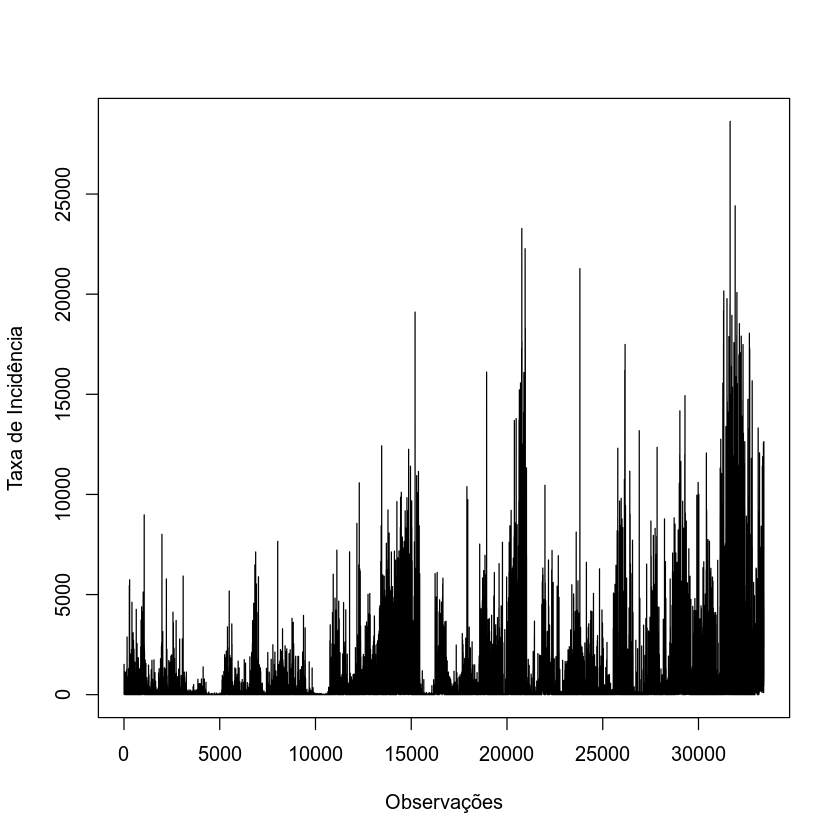

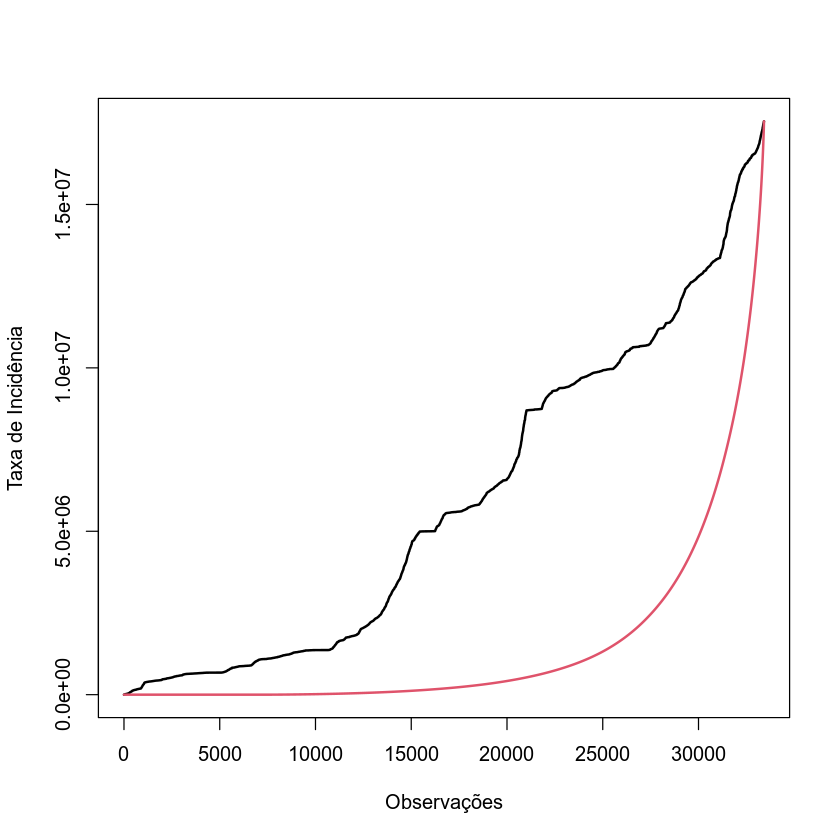

In [14]:
plot.ts(as.numeric(unlist(Arbo[,40:45])),xlab='Observações',ylab='Taxa de Incidência')
plot.ts(cumsum(as.numeric(unlist(Arbo[,40:45]))),lwd=2,xlab='Observações',ylab='Taxa de Incidência')
lines(cumsum(sort(as.numeric(unlist(Arbo[,40:45])))),lwd=2,col=2)

In [15]:
# Distribuição Empírica da Probabilidade de Frequência do Desfecho
DEPFD<-ecdf(unique(as.numeric(unlist(Arbo[,c(40:45)]))))

# Utilizou-se o valor médio (2017-2022) da taxa de ocorrência do desfecho para criar o perfil médio de probabilidade de ocorrência.

datah[,5]<-DEPFD(datah[,4])

# Categorizou-se a informação referente ao perfil médio de probabilidade de ocorrência, sendo os valores inferiores ou iguais a 0.4 rotulados como 0 (ocorrência baixa ou não ocorrência) e valores superiores a 0.4 como 1 (ocorrência moderada, alta ou muito alta).

datah[,3]<-ifelse(datah[,5]<=0.4,0,1)

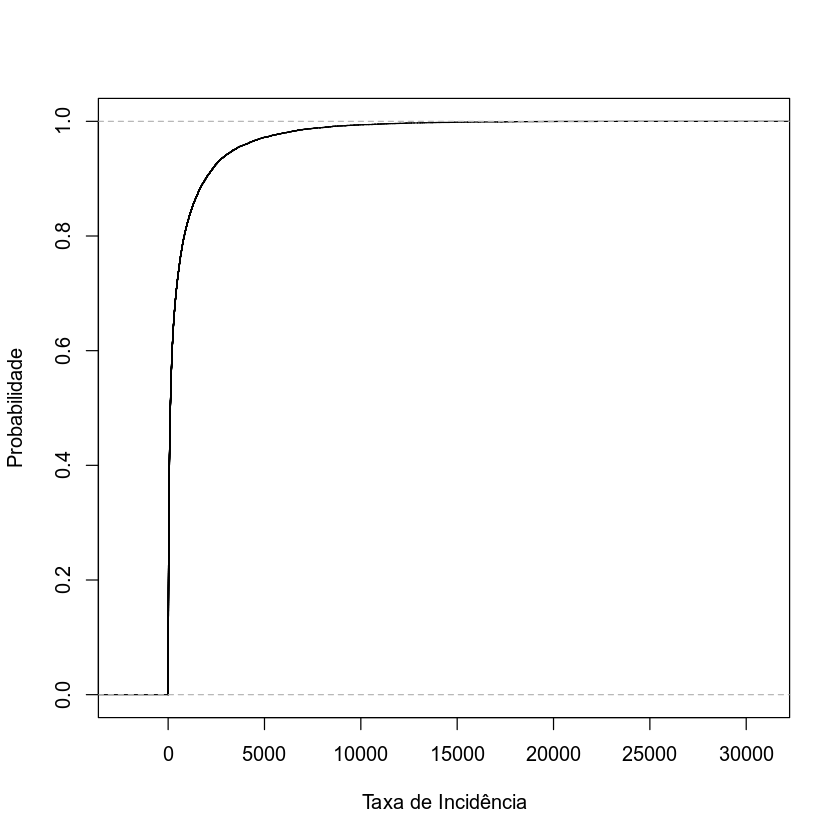

In [16]:
plot(DEPFD,xlab='Taxa de Incidência',ylab='Probabilidade',main='')

In [17]:
head(datah)

,GEOCOD,NM_MUN,CAT,PDMED,PROB,AMPT,HURS,RAIN,TASMAX,TASMIN,WSDI_D,WSDI_C
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1100015,Alta Floresta D'Oeste,1,505.1510,0.7299140,0.8558483,0.50,0.39,0.87,0.63,0.3668166,0.3628449
2,1100023,Ariquemes,1,250.4456,0.6291917,0.7033558,0.50,0.43,0.87,0.68,0.3683893,0.3580016
3,1100049,Cacoal,1,484.0213,0.7235382,0.7574339,0.41,0.40,0.86,0.66,0.3668166,0.3580016
4,1100056,Cerejeiras,1,502.3173,0.7292684,0.8637762,0.44,0.36,0.86,0.62,0.3755990,0.3676119
5,1100064,Colorado do Oeste,1,155.5272,0.5515516,0.8161036,0.46,0.42,0.80,0.58,0.3571637,0.3530795
6,1100080,Costa Marques,1,103.2916,0.4802066,0.7458377,0.45,0.38,0.87,0.67,0.3652338,0.3480761


In [18]:
DADO_MOD1   <-  datah[which(datah[,3]==1),]
DADO_MOD0   <-  datah[which(datah[,3]==0),]

dim(DADO_MOD1)
dim(DADO_MOD0)

[1] 4058   12

[1] 1511   12

In [19]:
tamanho_amostral<-min(NROW(DADO_MOD0),NROW(DADO_MOD1))

print(tamanho_amostral)

[1] 1511


In [20]:
amostra1     <- sample(c(TRUE, FALSE),tamanho_amostral,replace=TRUE,prob=c(0.7,0.3))
amostra2     <- sample(c(TRUE, FALSE),tamanho_amostral,replace=TRUE,prob=c(0.7,0.3))

dado.train  <- rbind(DADO_MOD1[which(amostra1==T), ],DADO_MOD0[which(amostra2==T),])
dado.test   <- rbind(DADO_MOD1[which(amostra1==F), ],DADO_MOD0[which(amostra2==F),])  

In [21]:
dim(dado.train)
dim(dado.test)

[1] 2123   12

[1] 899  12

In [22]:
head(dado.train)

,GEOCOD,NM_MUN,CAT,PDMED,PROB,AMPT,HURS,RAIN,TASMAX,TASMIN,WSDI_D,WSDI_C
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1100015,Alta Floresta D'Oeste,1,505.1510,0.7299140,0.8558483,0.50,0.39,0.87,0.63,0.3668166,0.3628449
2,1100023,Ariquemes,1,250.4456,0.6291917,0.7033558,0.50,0.43,0.87,0.68,0.3683893,0.3580016
3,1100049,Cacoal,1,484.0213,0.7235382,0.7574339,0.41,0.40,0.86,0.66,0.3668166,0.3580016
4,1100056,Cerejeiras,1,502.3173,0.7292684,0.8637762,0.44,0.36,0.86,0.62,0.3755990,0.3676119
8,1100106,Guajará-Mirim,1,133.2630,0.5258061,0.6944804,0.52,0.43,0.85,0.67,0.3510731,0.3378141
9,1100114,Jaru,1,544.7985,0.7396796,0.7124336,0.47,0.42,0.85,0.66,0.3647039,0.3530795


In [23]:
table(dado.train$CAT)


   0    1 
1042 1081 

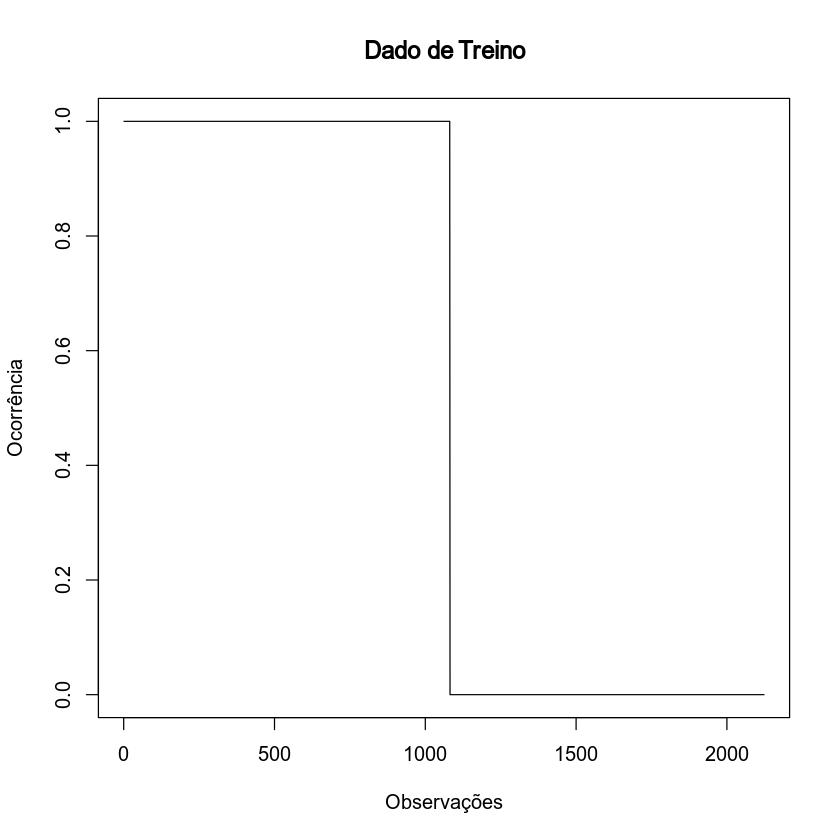

In [24]:
plot.ts(dado.train$CAT,main='Dado de Treino',xlab='Observações',ylab='Ocorrência')

In [25]:
dado.train2	<- dado.train[sample(sample(order(dado.train[,5]))),]
dado.test2	<- dado.test[sample(sample(order(dado.test[,5]))),]

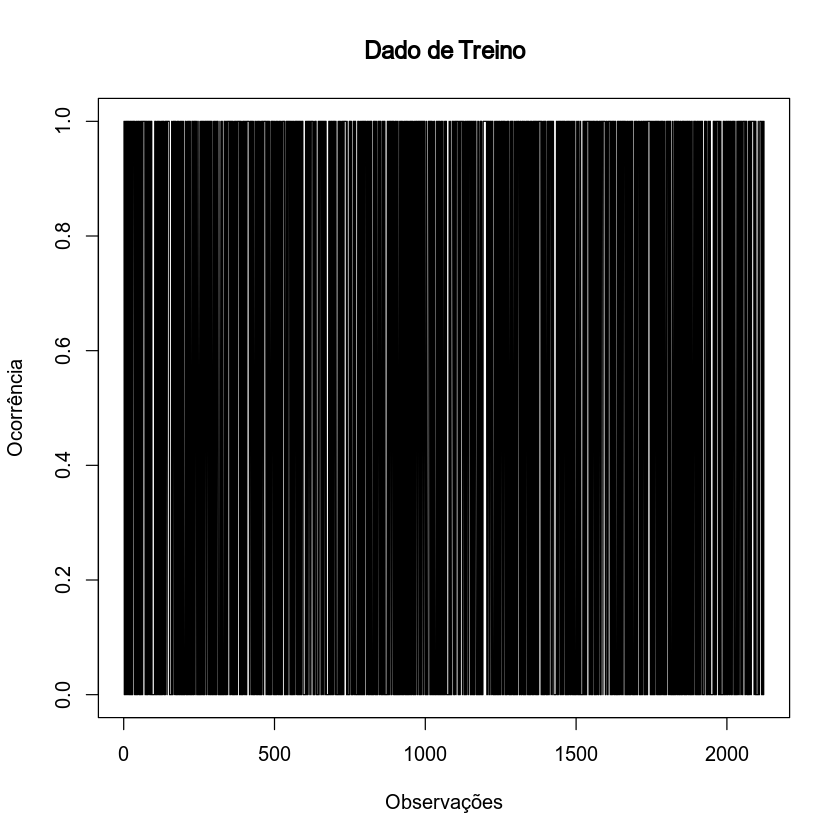

In [26]:
plot.ts(dado.train2$CAT,main='Dado de Treino',xlab='Observações',ylab='Ocorrência')

In [27]:
model.l1<-glm(formula=CAT~AMPT+RAIN+TASMAX+TASMIN+HURS,offset=WSDI_C,data=dado.train2,family='binomial') # AUROC 0.8156

#model.l1<-glm(formula=CAT~AMPT+RAIN+TASMAX+TASMIN+HURS+WSDI_C+WSDI_D,data=dado.train2,family='binomial') # AUROC 0.8156

#model.l1<-glm(formula=CAT~AMPT+RAIN+TASMAX+TASMIN+HURS,data=dado.train2,family='binomial') # AUROC 0.8156

model.l12<-step(model.l1)

summary(model.l1)

summary(model.l12)

Start:  AIC=2352.7
CAT ~ AMPT + RAIN + TASMAX + TASMIN + HURS

         Df Deviance    AIC
- AMPT    1   2341.7 2351.7
<none>        2340.7 2352.7
- TASMAX  1   2345.2 2355.2
- TASMIN  1   2364.5 2374.5
- HURS    1   2373.3 2383.3
- RAIN    1   2421.1 2431.1

Step:  AIC=2351.7
CAT ~ RAIN + TASMAX + TASMIN + HURS

         Df Deviance    AIC
<none>        2341.7 2351.7
- HURS    1   2377.5 2385.5
- TASMAX  1   2388.0 2396.0
- RAIN    1   2435.7 2443.7
- TASMIN  1   2544.7 2552.7



Call:
glm(formula = CAT ~ AMPT + RAIN + TASMAX + TASMIN + HURS, family = "binomial", 
    data = dado.train2, offset = WSDI_C)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4982  -0.8780   0.4557   0.8907   2.3559  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.4772     0.4630   1.031   0.3027    
AMPT         -0.7845     0.7790  -1.007   0.3140    
RAIN         -3.9383     0.4506  -8.740  < 2e-16 ***
TASMAX       -2.9942     1.4344  -2.087   0.0368 *  
TASMIN        7.4078     1.5731   4.709 2.49e-06 ***
HURS         -1.9540     0.3477  -5.619 1.92e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2901.0  on 2122  degrees of freedom
Residual deviance: 2340.7  on 2117  degrees of freedom
AIC: 2352.7

Number of Fisher Scoring iterations: 4



Call:
glm(formula = CAT ~ RAIN + TASMAX + TASMIN + HURS, family = "binomial", 
    data = dado.train2, offset = WSDI_C)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4975  -0.8789   0.4583   0.8907   2.3658  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.09524    0.26335   0.362    0.718    
RAIN        -4.07438    0.43095  -9.454  < 2e-16 ***
TASMAX      -4.29461    0.64739  -6.634 3.27e-11 ***
TASMIN       8.85445    0.66650  13.285  < 2e-16 ***
HURS        -1.78419    0.30242  -5.900 3.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2901.0  on 2122  degrees of freedom
Residual deviance: 2341.7  on 2118  degrees of freedom
AIC: 2351.7

Number of Fisher Scoring iterations: 4


In [28]:
coefficients(model.l12)

round(coefficients(model.l12)/sum(abs(coefficients(model.l12))),2)


(Intercept)        RAIN      TASMAX      TASMIN        HURS 
 0.09524145 -4.07438495 -4.29461182  8.85445198 -1.78419173

(Intercept)        RAIN      TASMAX      TASMIN        HURS 
       0.00       -0.21       -0.22        0.46       -0.09

In [29]:
coefficients(model.l1)

round(coefficients(model.l1)/sum(abs(coefficients(model.l1))),2)


(Intercept)        AMPT        RAIN      TASMAX      TASMIN        HURS 
  0.4771691  -0.7844668  -3.9382798  -2.9942207   7.4077952  -1.9539575

(Intercept)        AMPT        RAIN      TASMAX      TASMIN        HURS 
       0.03       -0.04       -0.22       -0.17        0.42       -0.11

: 

In [32]:
hl_gof.l1 <- hoslem.test(dado.train2$CAT, fitted(model.l1), g = 10)
hl_gof.l12 <- hoslem.test(dado.train2$CAT, fitted(model.l12), g = 10)

print(hl_gof.l1)
print(hl_gof.l12)




	Hosmer and Lemeshow goodness of fit (GOF) test

data:  dado.train2$CAT, fitted(model.l1)
X-squared = 81.812, df = 8, p-value = 2.109e-14


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  dado.train2$CAT, fitted(model.l12)
X-squared = 78.608, df = 8, p-value = 9.315e-14



In [33]:
predicted.l1 <- predict(model.l1,dado.test, type="response")
predicted.l12<-predict(model.l12,dado.test, type="response")

In [34]:
OPT.model.l1<-optimalCutoff(actuals=dado.test$CAT,predictedScores=predicted.l1)
OPT.model.l12<-optimalCutoff(actuals=dado.test$CAT,predictedScores=predicted.l12)

print(OPT.model.l1)
print(OPT.model.l12)



[1] 0.3254149
[1] 0.323584


In [35]:
confusionMatrix(dado.test$CAT, predicted.l1, threshold=OPT.model.l1)
confusionMatrix(dado.test$CAT, predicted.l12, threshold=OPT.model.l12)


,0,1
,<int>,<int>
0,242,34
1,188,435


,0,1
,<int>,<int>
0,239,30
1,191,439


In [36]:
# true positive rate
sensitivity(dado.test$CAT, predicted.l1, threshold=OPT.model.l1)
sensitivity(dado.test$CAT, predicted.l12, threshold=OPT.model.l12)


[1] 0.9275053

[1] 0.9360341

In [37]:

# true negative rate
specificity(dado.test$CAT, predicted.l1, threshold=OPT.model.l1)
specificity(dado.test$CAT, predicted.l12, threshold=OPT.model.l12)


[1] 0.5627907

[1] 0.555814

In [38]:

# percentage of total incorrect
misClassError(dado.test$CAT, predicted.l1, threshold=OPT.model.l1)
misClassError(dado.test$CAT, predicted.l12, threshold=OPT.model.l12)

[1] 0.2469

[1] 0.2458

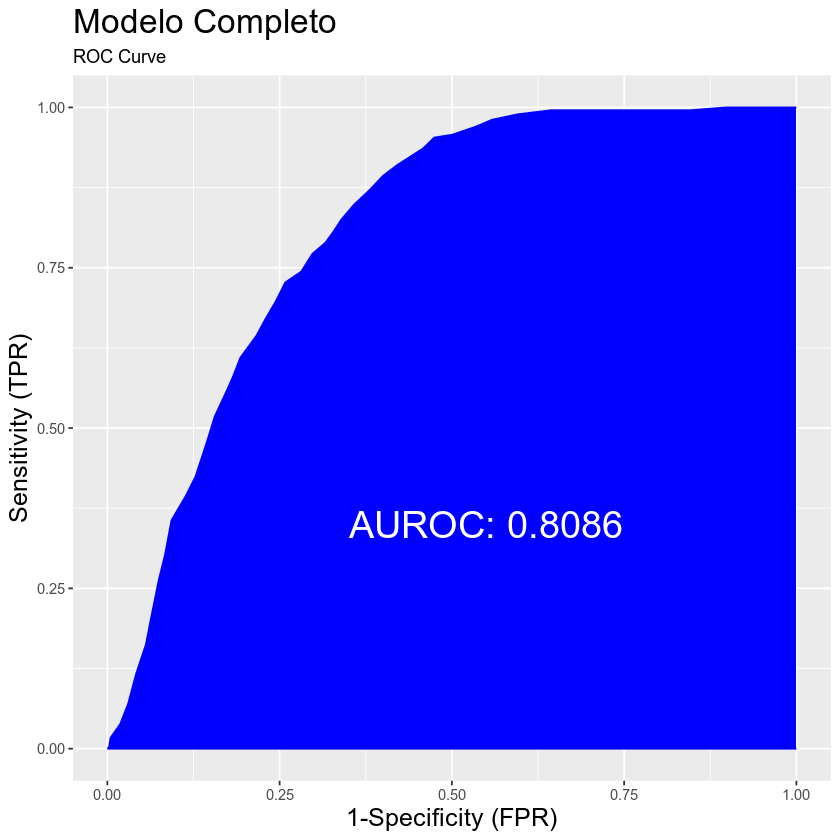

In [39]:
plotROC(dado.test$CAT, predicted.l1,'Modelo Completo')

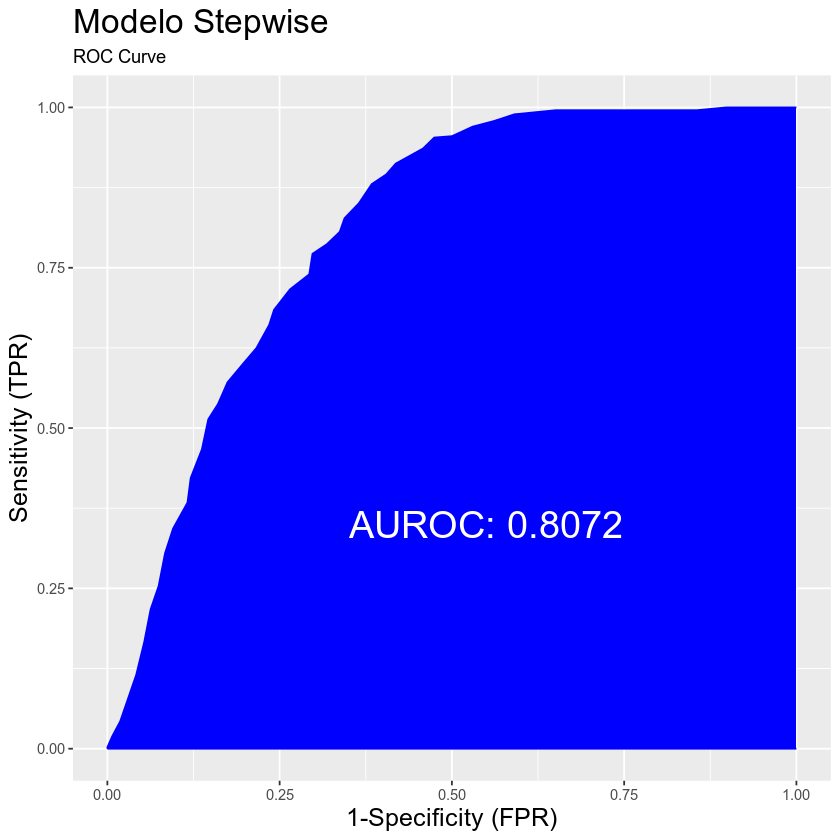

In [40]:
plotROC(dado.test$CAT, predicted.l12,'Modelo Stepwise')

In [41]:
head(data2030O)

,GEOCOD,NM_MUN,AMPT,HURS,RAIN,TASMAX,TASMIN,WSDI_D,WSDI_C
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1100015,Alta Floresta D'Oeste,0.9471528,0.46,0.43,0.95,0.67,0.7916144,0.8342418
2,1100023,Ariquemes,0.8010333,0.45,0.44,0.96,0.74,0.7925522,0.8249905
3,1100049,Cacoal,0.8719066,0.38,0.42,0.95,0.70,0.8024601,0.8332278
4,1100056,Cerejeiras,0.9638507,0.41,0.40,0.94,0.66,0.7960839,0.8402559
5,1100064,Colorado do Oeste,0.8942002,0.42,0.46,0.88,0.63,0.7946959,0.8291372
6,1100080,Costa Marques,0.8059811,0.41,0.42,0.96,0.73,0.7853335,0.8291372


In [42]:
output<-data.frame(CD_MUN=data2030O[,1],NM_MUN=data2030O[,2],
                    Hist=NA,C2030_O=NA,C2030_P=NA,C2050_O=NA,C2050_P=NA)

output[,3] <- predict(model.l1,datah, type="response")
output[,4] <- predict(model.l1,data2030O, type="response")
output[,5] <- predict(model.l1,data2030P, type="response")
output[,6] <- predict(model.l1,data2050O, type="response")
output[,7] <- predict(model.l1,data2050P, type="response")

In [43]:
write.xlsx(output,file='../4-Output/ameaça_full_arbovirose_20240923.xlsx')

In [44]:
output2<-data.frame(CD_MUN=data2030O[,1],NM_MUN=data2030O[,2],
                    Hist=NA,C2030_O=NA,C2030_P=NA,C2050_O=NA,C2050_P=NA)

output2[,3] <- predict(model.l12,datah, type="response")
output2[,4] <- predict(model.l12,data2030O, type="response")
output2[,5] <- predict(model.l12,data2030P, type="response")
output2[,6] <- predict(model.l12,data2050O, type="response")
output2[,7] <- predict(model.l12,data2050P, type="response")

In [45]:
write.xlsx(output2,file='../4-Output/ameaça_step_arbovirose_20240923.xlsx')

In [ ]:
head(output)

In [46]:
map_output<-Index.map(map0,output,2)

In [47]:
map_output2<-Index.map(map0,output2,2)

In [48]:
descr<-data.frame(ID=c('Hist','C2030_O','C2030_P','C2050_O','C2050_P'),
                TITULO=c('Potencial Climático para Ocorrência de \nArboviroses - Período Histórico',
                'Potencial Climático para Ocorrência de \nArboviroses - Período 2030 O',
                'Potencial Climático para Ocorrência de \nArboviroses - Período 2030 P',
                'Potencial Climático para Ocorrência de \nArboviroses - Período 2050 O',
                'Potencial Climático para Ocorrência de \nArboviroses - Período 2050 P'),
                COR=1)

In [49]:
Make.map(map_output,map_bac,descr,5,5,600,'Resultados_arbovirose_20240923',1,1,5)

In [50]:
Make.map(map_output2,map_bac,descr,5,5,600,'Resultados_arbovirose_stepwise_20240923',1,1,5)

In [ ]:
head(datah)

In [ ]:
map_arbo<-Index.map(map0,datah[,c(1:2,3,5)],2)

colnames(map_arbo@data)

In [71]:
descr0<-data.frame(ID=c('CAT','PROB'),
                    TITULO=c('Ocorrência de Arbovirose superior a 40%','Probabilidade de Ocorrência de \nArbovirose'),COR=1)

In [ ]:
head(descr0)

In [73]:
Make.map(map_arbo,map_bac,descr0,5,5,600,'Arbovirose',1,1,5)